<a href="https://colab.research.google.com/github/Sandhya-G/Aggression-Detection/blob/master/notebook/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

# **Summary**

CNN treats embedding matrix as an image, but in text case the convolution matrix must have same number of columns as that of embedding matrix and rows are usually 3,4 or 5 (can be thought of as bigrams, trigrams etc) even though its translation invariant it cannot take care of the context.
![cnn](https://miro.medium.com/max/500/0*0efgxnFIaLTZ2qkY?)

RNN remembers previous information using hidden state.
but it has two problems
Vanishing gradient (exploding gradient can be avoided  using Gradient clipping)
long term dependencies.
Hence variation of RNN
LSTM , bi-LSTM(both sides).
![LSTM unit](https://i.stack.imgur.com/aTDpS.png)
![deep lstm](https://assets.website-files.com/5ac6b7f2924c656f2b13a88c/5b883bbde817297a9cc204a9_Screen%20Shot%202018-08-29%20at%2011.05.17%20AM.png)
The architecture is same for GRU. LSTM is replaced by GRU.
![GRU unit](https://i.stack.imgur.com/PYGtu.png)

GRU(Simplified version of LSTM)


In [0]:
train_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TRAIN")
test_df = pd.read_csv("https://raw.githubusercontent.com/Sandhya-G/Aggression-Detection/master/dataset/GLOVE_TEST")

In [0]:
test_df.head()

,Unnamed: 0,Unnamed: 0.1,tweet,class
0,0,22583,what i look like ho ? i look like yes <allcaps...,1
1,1,29484,<user> lots of <hashtag> and <hashtag> from so...,0
2,2,34265,what is wrong with ppl nowadays ? i was conduc...,0
3,3,4155,<user> lakers are trash,1
4,4,37575,will be playing rf simpson in <hashtag> at <us...,0


In [0]:
embed_size = 300 # how big is each word vector
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

In [0]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [0]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

import tensorflow as tf


def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)


    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)




In [0]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

## split to train and val

train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=2048,stratify=train_df["class"])

## some config values 
embed_size = 100 # how big is each word vector
max_features = 30000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use

## fill up the missing values
train_X = train_df["tweet"].fillna("_na_").values
val_X = val_df["tweet"].fillna("_na_").values
test_X = test_df["tweet"].fillna("_na_").values

## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

## Pad the sentences 
train_X = pad_sequences(train_X, maxlen=maxlen,padding='post',truncating='post')
val_X = pad_sequences(val_X, maxlen=maxlen,padding='post',truncating='post')
test_X = pad_sequences(test_X, maxlen=maxlen,padding='post',truncating='post')

## Get the target values
train_y = train_df['class'].values
val_y = val_df['class'].values


        



In [0]:
def load_glove_index():
    EMBEDDING_FILE =  '/glove.twitter.27B.100d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:100]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    return embeddings_index

glove_embedding_index = load_glove_index()

In [0]:

num_words = max_features

embedding_matrix = np.zeros((num_words, embed_size))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = glove_embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(30000, 100)

In [0]:
from tensorflow.python.compiler import tensorrt as trt

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
model.compile(loss=f1_loss, optimizer='adam', metrics=['accuracy',f1])
print(model.summary())



Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 100, 100)          3000000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          63360     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17  

In [0]:
history = model.fit(train_X, train_y, batch_size=512, epochs=10, validation_data=(val_X, val_y))

Train on 38127 samples, validate on 4237 samples
Epoch 1/10
38127/38127 [==============================] - 29s 755us/step - loss: 0.0905 - accuracy: 0.9282 - f1: 0.9103 - val_loss: 0.0882 - val_accuracy: 0.9306 - val_f1: 0.9105
Epoch 2/10
38127/38127 [==============================] - 29s 750us/step - loss: 0.0906 - accuracy: 0.9279 - f1: 0.9098 - val_loss: 0.0865 - val_accuracy: 0.9311 - val_f1: 0.9127
Epoch 3/10
38127/38127 [==============================] - 29s 766us/step - loss: 0.0876 - accuracy: 0.9306 - f1: 0.9131 - val_loss: 0.0865 - val_accuracy: 0.9323 - val_f1: 0.9135
Epoch 4/10
38127/38127 [==============================] - 29s 757us/step - loss: 0.0868 - accuracy: 0.9312 - f1: 0.9137 - val_loss: 0.0859 - val_accuracy: 0.9318 - val_f1: 0.9142
Epoch 5/10
38127/38127 [==============================] - 28s 746us/step - loss: 0.0855 - accuracy: 0.9319 - f1: 0.9151 - val_loss: 0.0858 - val_accuracy: 0.9313 - val_f1: 0.9148
Epoch 6/10
38127/38127 [==============================] 

In [0]:
#codes from machinelearningmastery.com
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
# codes from machinelearningmastery.com
def print_hist(history):
    plt.plot(history.history['f1'])
    plt.plot(history.history['val_f1'])
    plt.title('model af1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

   
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    

dict_keys(['val_loss', 'val_accuracy', 'val_f1', 'loss', 'accuracy', 'f1'])


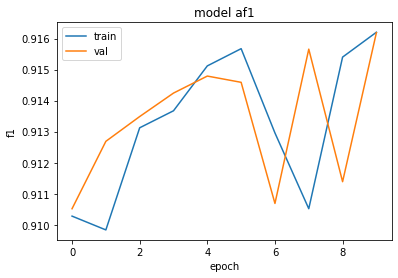

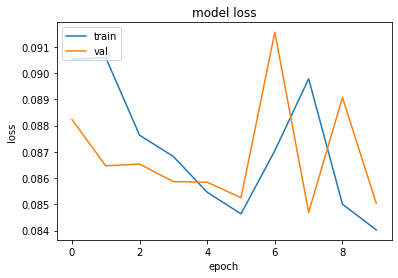

In [0]:
print_hist(history)

In [0]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable=False)(inp)
x = Bidirectional(GRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',f1])
print(model.summary())





Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 100, 100)          3000000   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100, 128)          63360     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17  

In [0]:
history = model.fit(train_X, train_y, batch_size=512, epochs=10, validation_data=(val_X, val_y))



Train on 38127 samples, validate on 4237 samples
Epoch 1/10
38127/38127 [==============================] - 30s 789us/step - loss: 0.3033 - accuracy: 0.8952 - f1: 0.8721 - val_loss: 0.2145 - val_accuracy: 0.9242 - val_f1: 0.9039
Epoch 2/10
38127/38127 [==============================] - 30s 782us/step - loss: 0.2239 - accuracy: 0.9223 - f1: 0.9032 - val_loss: 0.1942 - val_accuracy: 0.9273 - val_f1: 0.9088
Epoch 3/10
38127/38127 [==============================] - 30s 792us/step - loss: 0.2064 - accuracy: 0.9266 - f1: 0.9082 - val_loss: 0.1835 - val_accuracy: 0.9313 - val_f1: 0.9122
Epoch 4/10
38127/38127 [==============================] - 30s 786us/step - loss: 0.1940 - accuracy: 0.9308 - f1: 0.9134 - val_loss: 0.1778 - val_accuracy: 0.9332 - val_f1: 0.9156
Epoch 5/10
38127/38127 [==============================] - 30s 792us/step - loss: 0.1877 - accuracy: 0.9331 - f1: 0.9164 - val_loss: 0.1720 - val_accuracy: 0.9342 - val_f1: 0.9163
Epoch 6/10
38127/38127 [==============================] 

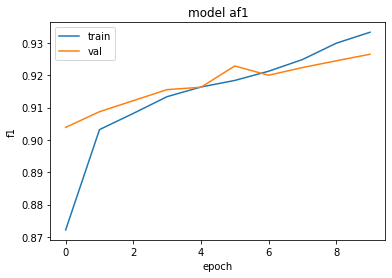

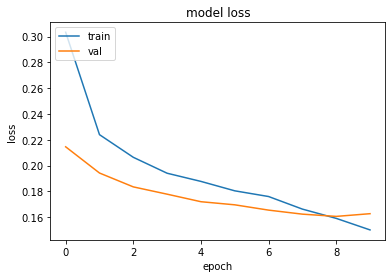

In [0]:

print_hist(history)

In [0]:
pred_glove_train_y = model.predict([train_X], batch_size=1024, verbose=1)
scores = []
thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
    thresh = np.round(thresh, 2)
    scores.append(metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int)))
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(train_y, (pred_glove_train_y>thresh).astype(int))))
idx = np.argmax(np.array(scores))
thresh_train = thresholds[idx]

38127/38127 [==============================] - 1s 36us/step
F1 score at threshold 0.1 is 0.9034607317641575
F1 score at threshold 0.11 is 0.9092564848271202
F1 score at threshold 0.12 is 0.9138951355189964
F1 score at threshold 0.13 is 0.9179946978046529
F1 score at threshold 0.14 is 0.9212251863828258
F1 score at threshold 0.15 is 0.9245731835837524
F1 score at threshold 0.16 is 0.9268971357711036
F1 score at threshold 0.17 is 0.9290941665907504
F1 score at threshold 0.18 is 0.9315235626048498
F1 score at threshold 0.19 is 0.9327087925544943
F1 score at threshold 0.2 is 0.9340216957069543
F1 score at threshold 0.21 is 0.9352171767028626
F1 score at threshold 0.22 is 0.9364007926678226
F1 score at threshold 0.23 is 0.9374650338782868
F1 score at threshold 0.24 is 0.9378273883761536
F1 score at threshold 0.25 is 0.9387512512512511
F1 score at threshold 0.26 is 0.9391915200551948
F1 score at threshold 0.27 is 0.939622641509434
F1 score at threshold 0.28 is 0.9404349196344154
F1 score at 

In [0]:
print(thresh_train)


0.32999999999999985


In [0]:
pred_glove_val_y = model.predict([val_X], batch_size=1024, verbose=1)
scores = []
thresholds = np.arange(0.1, 0.501, 0.01)
for thresh in thresholds:
    thresh = np.round(thresh, 2)
    scores.append(metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int)))
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(val_y, (pred_glove_val_y>thresh).astype(int))))
idx = np.argmax(np.array(scores))
thresh_valid = thresholds[idx]

4237/4237 [==============================] - 0s 43us/step
F1 score at threshold 0.1 is 0.8938401048492792
F1 score at threshold 0.11 is 0.8975919555437947
F1 score at threshold 0.12 is 0.9023479188900748
F1 score at threshold 0.13 is 0.903969957081545
F1 score at threshold 0.14 is 0.9046849757673667
F1 score at threshold 0.15 is 0.907958852192745
F1 score at threshold 0.16 is 0.9090909090909091
F1 score at threshold 0.17 is 0.9111779174637881
F1 score at threshold 0.18 is 0.9119824513298602
F1 score at threshold 0.19 is 0.9140495867768595
F1 score at threshold 0.2 is 0.9153761061946903
F1 score at threshold 0.21 is 0.9171056279456612
F1 score at threshold 0.22 is 0.9181969949916529
F1 score at threshold 0.23 is 0.9206260480715484
F1 score at threshold 0.24 is 0.92152466367713
F1 score at threshold 0.25 is 0.9238122012932247
F1 score at threshold 0.26 is 0.9256338028169014
F1 score at threshold 0.27 is 0.924816280384398
F1 score at threshold 0.28 is 0.9255168507504956
F1 score at thresh

In [0]:
print(thresh_valid)

0.47999999999999976


In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('total valid data is ',train_y.shape[0], 'where', np.sum(train_y==1),'is hate' )
print(accuracy_score(train_y, pred_glove_train_y>thresh_train))
confusion_matrix(train_y, pred_glove_train_y>thresh_train, labels=[0, 1])

total valid data is  38127 where 15888 is hate
0.9523434836205313


array([[21516,   723],
       [ 1094, 14794]])

In [0]:
print('total valid data is ',val_y.shape[0], 'where', np.sum(val_y==1),'is hate' )
print(accuracy_score(val_y, pred_glove_val_y>thresh_valid))
confusion_matrix(val_y, pred_glove_val_y>thresh_valid, labels=[0, 1])



total valid data is  4237 where 1764 is hate
0.9421760679726221


array([[2408,   65],
       [ 180, 1584]])

In [0]:
predicted = model.predict(test_X) > 0.32999999999999985


In [0]:
metrics.f1_score(predicted,test_df['class'])

0.9242393302021645